# Résolution de l'équation d'agrégation 1D par volumes finis

L'équation d'agrégation décrit le phénomène d'agrégation dans une population d'individus qui interagit sous un potentiel d'interaction continu $W$. Si $\rho$ désigne la densité d'individus, sa dynamique est donnée par l'équation de conservation suivante :

$$
\begin{cases}
\partial_t\rho &= \nabla . ((\nabla W * \rho)\rho), \\
\rho(0) &= \rho_0. \\
\end{cases}
$$

L'inconnue $\rho$ est une mesure de probabilité paramétrée par le temps (sur $[-1, 1]$ par exemple).
La première ligne est une EDP que l'on peut réécrire sous la forme suivante dans le cas 1D :

$$
\frac{\partial \rho}{\partial t} = \frac{\partial}{\partial x} \left((W' * \rho)\rho\right). \\
$$

La deuxième ligne correspond au profil initial de la mesure.

**Schéma utilisé :**

On se donne un maillage uniforme $-1 = x_0 < x_i < ... < x_N = 1~$ sur $[-1,1].$
On définit $\rho_i^n :=$ approximation de $\rho$ sur la cellule $\mathcal{C}_i:=[x_{i-1/2},x_{i+1/2}]$ au temps $t^n$.
$\rho_i^n$ est donné par le schéma suivant :

$$\rho_i^{n+1}=\rho_i^{n}-\frac{\Delta t}{\Delta x}(\mathcal{F}_{i+1/2}-\mathcal{F}_{i-1/2}).$$

avec :
$$\mathcal{F}_{i+1/2}=(a_i^n)^+\rho_i^n-(a_{i+1}^n)^-\rho_{i+1}^n,$$
et $$a_i^n=-\sum_{l=0}^{N}\rho_l^n W'(x_i-x_l).$$

Ce dernier terme est appelé vitesse macroscopique de la cellule $\mathcal{C}_i$ au temps $t^n$ ; car il s'agit de la discrétisation de la vitesse de l'EDP vue comme équation de transport.

Le schéma est décrit plus en détail dans [[1]](https://arxiv.org/pdf/1912.06423.pdf) et [[2]](https://arxiv.org/pdf/1602.05746.pdf).

## Sommaire :
* [Paramètres/fonctions du problème](#t1)
* [Remarque sur la normalisation de la condition initiale](#t2)
* [Calcul de la matrice des interactions et necessité de vectoriser](#t3)
* [Implémentation du schéma](#t4)
* [Optimisation avec FFT](#t5)
* [Et pourquoi pas des différences finies ?](#t6)

In [1]:
# Importations :
import numpy as np
import matplotlib.pyplot as plt
import os
import time

### Définition des paramètres et fonctions du problème <a class="anchor" id="t1"></a>

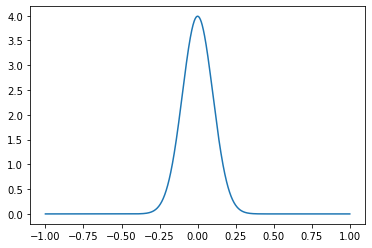

In [2]:
# Potentiel d'interaction et sa dérivée :
# W  = lambda x : np.abs(x) # Potentiel d'interaction
dxW = lambda x : np.sign(x) # Dérivée de W

# Fonction pour initialiser la solution :
rho_ini = lambda x : np.exp(-x*x/2/0.01)/np.sqrt(2*np.pi*0.01)

# Définition de la grille :
xmin = -1  # Borne de gauche du domaine
xmax = 1   # Borne de droite du domaine
Nx   = 1024 # Nombre de points de la discrétisation en espace
grid = np.linspace(xmin, xmax, Nx) # Grille
Dx   = grid[1]-grid[0] # Pas d'espace

# Discrétisation en temps :
Nt = 5000 # Nombre de points de la discrétisation en temps
tf = 1.   # Temps final
T  = np.linspace(0, tf, Nt) # Temps discrets
Dt = T[1]-T[0] # Pas de temps

plt.plot(grid, rho_ini(grid))
plt.show()

### Remarque sur la normalisation de la condition initiale <a class="anchor" id="t2"></a>

On constate expérimentalement que l'équation donne une masse de Dirac en temps fini. Ce comportement est l'analogue continu de la convergence des points au centre de masse dans le modèle discret. On peut alors remarquer que, pour le schéma volumes finis utilisé, une masse de Dirac correspond à toute la masse concentrée dans deux cellules (c'est le cas du moins sur les tests effectués). Comme le schéma a la propriété de conserver la masse, il est clair qu'on peut aboutir à un problème d'overflow quand le pas $\Delta x$ devient petit.

En normalisant la condition initiale, il est possible de raffiner le maillage sans rencontrer ce problème d'overflow. En faisant _rho /= sum(rho)_, on obtient une condition initiale dont la masse totale est $\Delta x$ :

$$\text{Masse totale}~ = \left(\sum_i \Delta x\rho_i\right)/\sum_i \rho_i = \Delta x.$$

Et alors comme une masse de Dirac correspond à toute la masse concentrée dans deux cellules , la hauteur de la mesure vérifie :

$$\text{Masse totale}~ = \Delta x = \text{hauteur}\times2\Delta x,$$

d'où l'on tire que la hauteur maximale est $1/2$. Expérimentalement, c'est bien ce qu'on retrouve aussi.

**Update :** en multipliant les exemples, on peut observer des cas où la masse de Dirac est concentrée dans une à deux cellules. Alors en fait la hauteur finale n'est pas exactement $1/2$ mais elle est comprise entre $1/2$ et $1$.

### Calcul de la matrice _Wp_ et necessité de vectoriser <a class="anchor" id="t3"></a>

On voit à la lecture du schéma qu'à chaque étape de temps, on va avoir besoin des valeurs $W'(x_i-x_l), ~
0\leq i,l\leq N$. Comme $W$ ne dépend pas du temps, on peut stocker ces valeurs une bonne fois pour toutes dans une matrice _Wp_ en dehors de la boucle en temps. Selon le raffinement du maillage, cette matrice peut admettre un nombre élevé de coefficients. Apparaît alors la necessité de vectoriser le calcul de cette matrice.

Avec le module _time_, on peut regarder à quel point la version vectorisée du calcul de _Wp_ est plus efficace. C'est ce qui est fait dans la cellule qui suit.

In [3]:
# Comparaison des vitesses d'execution :

# Première version, non vectorisée :
tps1 = time.time()
Wp = np.zeros((Nx, Nx))
for i,xi in enumerate(grid):
    for j,xj in enumerate(grid):
        Wp[i,j] = dxW(xi-xj)
tps2 = time.time()
print("Temps d’exécution pour la version non vectorisée :", tps2 - tps1)

# Seconde version, semi-vectorisée :
tps1 = time.time()
Wp = np.zeros((Nx, Nx))
for i,xi in enumerate(grid):
    Wp[i] = dxW(xi-grid)
tps2 = time.time()
print("Temps d’exécution pour la version semi-vectorisée :", tps2 - tps1)

# On peut faire encore mieux...
# Version totalement vectorisée :
tps1 = time.time()
Wp = dxW(np.tile(grid.reshape((Nx, 1)), (1, Nx)) - grid)
tps2 = time.time()
print("Temps d’exécution pour la version vectorisé :", tps2 - tps1)

Temps d’exécution pour la version non vectorisée : 1.6358962059020996
Temps d’exécution pour la version semi-vectorisée : 0.011240243911743164
Temps d’exécution pour la version vectorisé : 0.012778997421264648


Chaque vectorisation permet de gagner un temps considérable.

### Implémentation du schéma <a class="anchor" id="t4"></a>

Le calcul de _a_ peut se faire comme un produit matrice-vecteur. C'est ce qui est fait dans la cellule qui suit.

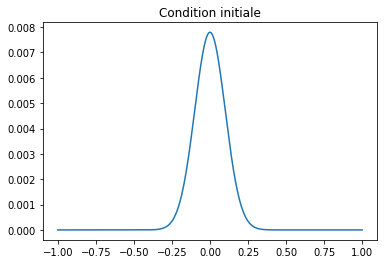

Masse totale initiale : 0.9999999999999994


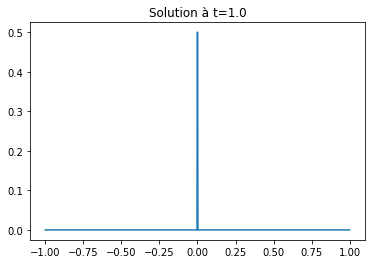

Masse totale finale : 0.9999999999999958


In [4]:
# Création du fichier pour la sauvegarde des figures :
if not os.path.exists('./figures1'):
    os.makedirs('./figures1')

tps1 = time.time() # Début chrono v1 du schéma

# Condition initiale :
rho  = rho_ini(grid)
s    = sum(rho)
rho /= s # Normalisation

# Plot de la condition initiale :
plt.plot(grid, rho)
plt.title("Condition initiale")
plt.show()
print("Masse totale initiale :", sum(rho))

a      = np.zeros(Nx) # Pour la vitesse macroscopique a
rho_dp = np.zeros(Nx) # Pour contenir un vecteur "avec décalage"
rho_gm = np.zeros(Nx) # Pour contenir un vecteur "avec décalage"

# Calcul de Wp :
Wp = dxW(np.tile(grid.reshape((Nx, 1)), (1, Nx)) - grid)

# Boucle de résolution :
cpt = 0 # Nombre de sauvegardes
for n,t in enumerate(T):

    # Calcul de la vitesse macroscopique a :
    # (Avec produit matriciel)
    a = - np.dot(Wp,rho)
    
    # Mise à jour de rho :
    ap = a*(a>0)  # Partie positive de a
    am = -a*(a<0) # Partie négative de a
    rho_dp[1:]  = ap[:-1]*rho[:-1]
    rho_gm[:-1] = am[1:]*rho[1:]
    rho -= Dt/Dx*(ap*rho-rho_gm-rho_dp+am*rho)
    
    # Pour un affichage de la solution à intervalles réguliers :
    if (not n%100):
        cpt += 1
        r = round(t, 2)
        plt.plot(grid, rho)
        plt.ylim([0, 0.6])
        plt.title("t = "+str(r))
        plt.savefig("./figures1/etape"+str(cpt)+".pdf", facecolor='white', transparent=False)
        plt.clf()
        #plt.show()
        #print("t =", r, "; masse totale :", s*Dx*sum(rho))

tps2 = time.time() # Fin chrono v1 du schéma

# Plot de la solution finale :
plt.plot(grid, rho)
plt.title("Solution à t="+str(round(t, 2)))
plt.show()
print("Masse totale finale :", sum(rho))

### Optimisation avec FFT <a class="anchor" id="t5"></a>

Nous allons voir une autre façon de calculer la vitesse macroscopique qui repose sur la structure particulière de la matrice et l'utilisation de la FFT. Cette autre façon de faire sera non seulement plus efficace en temps (grâce à la FFT) mais aussi en espace (puisqu'elle permettra de ne stocker qu'une partie des coefficients la matrice _Wp_).

**Plus précisément :** on souhaite calculer efficacement $a_i^n=-\sum_{l=0}^{N}\rho_l^n W'(x_i-x_l).$ On a vu que ça pouvait être fait comme un produit matrice-vecteur  _a = - np.dot(Wp, rho)_. Mais _Wp_ n'est pas quelconque. Il s'agit d'une [matrice de Toeplitz](https://fr.wikipedia.org/wiki/Matrice_de_Toeplitz). En effet, le coefficient $(i,j)$ de _Wp_ est égal à $W'(x_i-x_j) = W'(x_{i+1}-x_{j+1})$ (dans le cas d'un maillage uniforme) ; c'est à dire le coefficient $(i+1,j+1)$ de _Wp_. Le produit de cette matrice avec un vecteur peut alors être fait en utilisant _scipy.linalg.matmul_toeplitz_ (plus de détails [ici](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.matmul_toeplitz.html)). La fonction repose sur l'utilisation de la FFT, ce qui la rend asymptotiquement plus efficace qu'un _np.dot_. La documentation explique que seules la première ligne et la première colonne sont nécessaires. En plus de ça, la matrice est antisymétrique (car $W$ est paire). Alors on a juste besoin de stocker la première ligne (ou la première colonne).

In [5]:
from scipy.linalg import matmul_toeplitz # Pour multiplier des matrices de Toeplitz

# Création du fichier pour la sauvegarde des figures :
if not os.path.exists('./figures2'):
    os.makedirs('./figures2')
    
tps3 = time.time() # Début chrono v2 du schéma

# Condition initiale :
rho  = rho_ini(grid)
s    = sum(rho)
rho /= s # Normalisation

a      = np.zeros(Nx) # Pour la vitesse macroscopique a
rho_dp = np.zeros(Nx) # Pour contenir un vecteur "avec décalage"
rho_gm = np.zeros(Nx) # Pour contenir un vecteur "avec décalage"

# Calcul de la première ligne de Wp
l = dxW(grid[0]-grid)

# Boucle de résolution :
cpt = 0 # Nombre de sauvegardes
for n,t in enumerate(T):

    # Calcul de la vitesse macroscopique a :
    # (Avec FFT sous-jacente)
    a = -matmul_toeplitz((-l, l), rho)
    
    # Mise à jour de rho :
    ap = a*(a>0)  # Partie positive de a
    am = -a*(a<0) # Partie négative de a
    rho_dp[1:]  = ap[:-1]*rho[:-1]
    rho_gm[:-1] = am[1:]*rho[1:]
    rho -= Dt/Dx*(ap*rho-rho_gm-rho_dp+am*rho)
    
    # Pour un affichage de la solution à intervalles réguliers :
    if (not n%100):
        cpt += 1
        r = round(t, 2)
        plt.plot(grid, rho)
        plt.ylim([0, 0.6])
        plt.title("t = "+str(r))
        plt.savefig("./figures2/etape"+str(cpt)+".pdf", facecolor='white', transparent=False)
        plt.clf()
        #plt.show()
        #print("t =", r, "; masse totale :", s*Dx*sum(rho))
        
tps4 = time.time() # Fin chrono v2 du schéma

print("Le schéma avec FFT est ", (tps2-tps1)/(tps4-tps3), "plus rapide avec les paramètres donnés.")

Le schéma avec FFT est  1.0426906905242086 plus rapide avec les paramètres donnés.


<Figure size 432x288 with 0 Axes>

### Et pourquoi pas des différences finies ? <a class="anchor" id="t6"></a>

A priori, ça **n'est pas une bonne idée** dans la mesure où la solution va converger vers une masse de Dirac ; qui n'est pas une fonction dérivable. Rien n'empêche d'essayer quand même. La discrétisation proposée est la suivante :

$$ \frac{\rho_i^{n+1}-\rho_i^{n}}{\Delta t} = \frac{\rho_{i+1}^{n}(W'*\rho^n)_{i+1}-\rho_{i-1}^{n}(W'*\rho^n)_{i-1}}{2 \Delta x}.$$

Et en notant $a_i^n$ la discrétisation de la vitesse macroscopique :

$$ \rho_i^{n+1} = \rho_i^{n} + \frac{\Delta t}{2 \Delta x}\left(\rho_{i+1}^n a_{i+1}^n-\rho_{i-1}^n a_{i-1}^n \right).$$

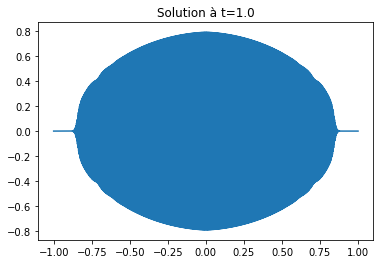

Masse totale finale : 1.0000000000000078


In [6]:
# Création du fichier pour la sauvegarde des figures :
if not os.path.exists('./figures3'):
    os.makedirs('./figures3')

Wp = dxW(np.tile(grid.reshape((Nx, 1)), (1, Nx)) - grid)

# Condition initiale :
rho  = rho_ini(grid)
s    = sum(rho)
rho /= s # Normalisation

# Plot de la condition initiale :
#plt.plot(grid, rho)
#plt.show()
#print("Masse totale initiale :", sum(rho))

a      = np.zeros(Nx) # Pour la vitesse macroscopique a
rhoa_d = np.zeros(Nx) # Pour contenir un vecteur "avec décalage"
rhoa_g = np.zeros(Nx) # Pour contenir un vecteur "avec décalage"

# Calcul de Wp "factorisé"
Wp = dxW(np.tile(grid.reshape((Nx, 1)), (1, Nx)) - grid)

# Boucle de résolution :
cpt = 0 # Nombre de sauvegardes
for n,t in enumerate(T):

    # Calcul de la vitesse macroscopique a :
    # (Avec produit matriciel)
    a = np.dot(Wp, rho)
    
    # Mise à jour de rho :
    rhoa_d[1:]  = a[:-1]*rho[:-1]
    rhoa_g[:-1] = a[1:]*rho[1:]
    rho += 0.5*Dt/Dx*(rhoa_g - rhoa_d)
    
    # Pour un affichage de la solution à intervalles réguliers :
    if (not n%100):
        cpt += 1
        r = round(t, 2)
        plt.plot(grid, rho)
        plt.ylim([0, 0.6])
        plt.title("t = "+str(r))
        plt.savefig("./figures3/etape"+str(cpt)+".pdf", facecolor='white', transparent=False)
        plt.clf()
        #plt.show()
        #print("t =", r, "; masse totale :", sum(rho))

# Plot de la solution finale :
plt.plot(grid, rho)
plt.title("Solution à t="+str(round(t, 2)))
plt.show()
print("Masse totale finale :", sum(rho))

**Ça ne marche clairement pas.**
Encore une fois, il est necessaire de normaliser pour ne pas obtenir d'overflow dès les premières itérations. La dynamique semble correcte pour des temps très petits, tant que la solution n'est pas trop pointue. Passé le dixième de seconde, les résultats commencent à devenir mauvais.